# Modules

Import modules (`numpy`, `scipy`, `xarray`, and `matplotlib` required)

In [1]:
from typing import Tuple

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import t, linregress

# Data

Load processed data into the notebook. The dataset contains 9 time series: 3 variables from 3 model simulations:

Variables:
- Global mean sea surface temperature (`sst`; unit of K)
- Mean sea ice area fraction in the Northern Hemisphere (`ice_nh`; unitless from 0 to 100)
- Mean sea ice fraction in the Southern Hemisphere (`ice_sh`; unitless from 0 to 100)

Model simulations:
- `sim1` (from 1979 to 2023)
- `sim2` (from 1982 to 2023)
- `sim3` (from 1979 to 2021)

Tip: If processing datasets is time-consuming, you can save processed, intermediate data into a file so that you won't repeat the process again and again. This can be done with the `pickle` module or the `Dataset.to_netcdf` function from the `xarray` module.

In [3]:
data = xr.open_dataset('data.nc')
data

<xarray.Dataset> Size: 43kB
Dimensions:      (time: 540)
Coordinates:
  * time         (time) datetime64[ns] 4kB 1979-01-15 1979-02-15 ... 2023-12-15
Data variables:
    sim1.sst     (time) float64 4kB ...
    sim1.ice_nh  (time) float64 4kB ...
    sim1.ice_sh  (time) float64 4kB ...
    sim2.sst     (time) float64 4kB ...
    sim2.ice_nh  (time) float64 4kB ...
    sim2.ice_sh  (time) float64 4kB ...
    sim3.sst     (time) float64 4kB ...
    sim3.ice_nh  (time) float64 4kB ...
    sim3.ice_sh  (time) float64 4kB ...

Below is a helper function to remove climatology and calculate linear trends and 95% confidence interval from the time series.

Note: This function assumes that the month length is constant. How do you modify the function so that it takes into account different days in each month?

In [4]:
def getTrend(y:xr.DataArray) -> Tuple[float, float]:
  """
  Remove the seasonal cycle from the data and compute the linear trend
  in the anomalies. The trend is returned in units of */decade.

  Arguments:
    y: DataArray with time as the only dimension.
  Returns:
    slope: The slope of the linear trend in units of */decade.
    ci: The 95% confidence interval for the slope in units of */decade.
  """
  y_climo = y.sel(time=slice('2001-01-01', '2021-12-31')).groupby('time.month').mean('time')
  y_anomaly = xr.apply_ufunc(
    lambda x, m: x - m,
    y.groupby('time.month'), y_climo
  ).drop_vars('month')
  lr = linregress(np.arange(len(y_anomaly)), y_anomaly)
  slope = lr.slope * 120
  ci = lr.stderr * 120 * t.ppf(0.975, len(y_anomaly)-2)
  return slope, ci

# Plot

Our goal is to plot the time series of each variable across different model simulations and compute the trends and 95% confidence intervals of each time series in three different time periods (1982~2021, 2001~2021, and 2011~2021).

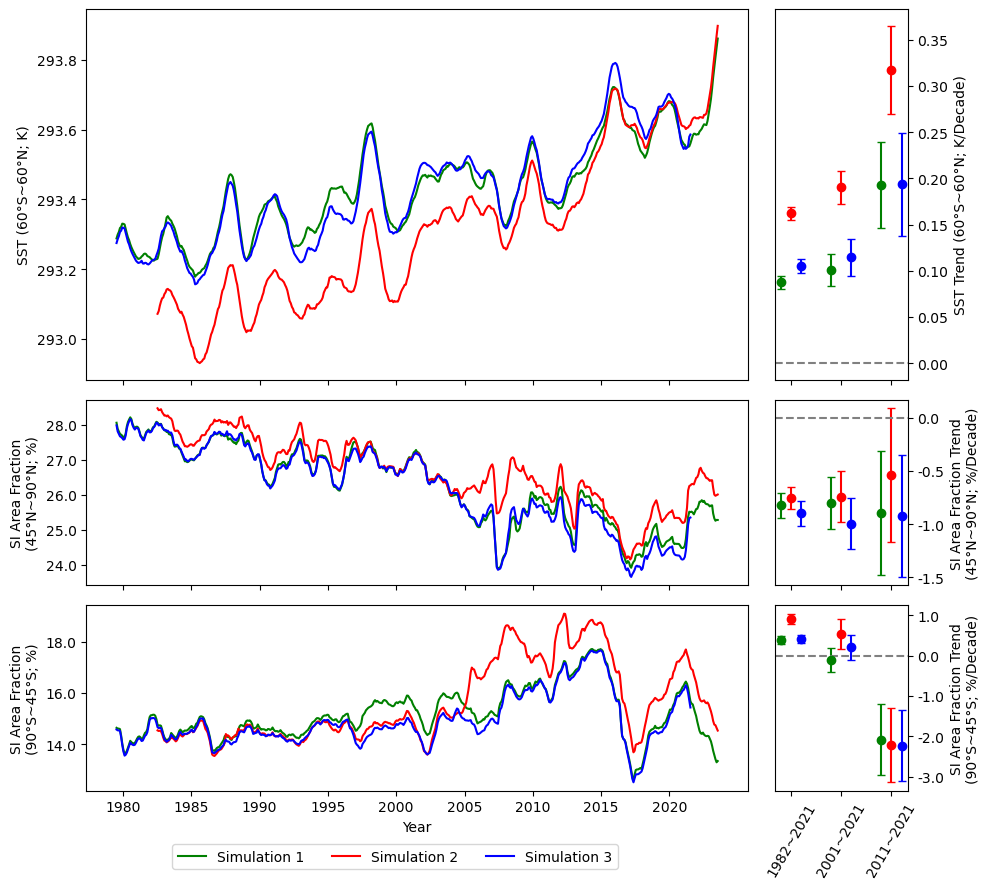

In [5]:
# Create a figure with subplots
# Note the use of `height_ratios` and `width_ratios` to adjust subplot sizes
# and `sharex` to share the x-axis (time or time period) across columns.
# `axs`` is a 2D array of Axes objects, the first index is row and the second index is column.
fig, axs = plt.subplots(3, 2, figsize=(10, 9), height_ratios=(2, 1, 1),
                        width_ratios=(5, 1), sharex="col")

# Loop over different model simulations
# product: the product name
# plabel: the label for each product that will be used in the legend
# color: the color for the line plot ()
for i, product, plabel, color in zip(
  range(3),
  ['sim1', 'sim2', 'sim3'],
  ['Simulation 1', 'Simulation 2', 'Simulation 3'],
  ['g', 'r', 'b']
):
  # Loop over different variables
  # var: the variable name (e.g., 'sst', 'ice_nh', 'ice_sh')
  for j, var in zip(range(3), ['sst', 'ice_nh', 'ice_sh']):
    # Plot the left column: time series of the variable
    # We apply a 12-month rolling mean to smooth the time series for better visualization
    key = f'{product}.{var}'
    y = data[key].rolling(time=12, center=True).mean()

    # axs[j, 0] is the left column for time series plots
    # label will be used in the legend
    axs[j, 0].plot(y.time, y, '-', label=plabel, color=color)

    # Plot the right column: trends in the variable
    # We compute the trend for three different time slices
    for k, tslice in enumerate((
      slice('1982-01-01', '2021-12-31'),
      slice('2001-01-01', '2021-12-31'),
      slice('2011-01-01', '2021-12-31'),
    )):
      # Compute the trend for the selected time slice
      # You can parse a slice object into the `sel` method to select a time range
      # The trend is computed using the `getTrend` function defined above
      y = data[key].sel(time=tslice)
      slope, ci = getTrend(y)

      # axs[j, 1] is the right column for trend plots
      # We use error bars to show the slope and its confidence interval
      # The x-coordinate is adjusted to separate the points for different time slices
      # Here we have 3 model simulations, so we multiply the index by 5 to space them out
      # ensuring that we have double spaces across different average periods
      axs[j, 1].errorbar(5 * k + i, slope, ci, fmt='o', color=color, capsize=3)

# Set custom x-ticks
# This is important for the right column where we show trends
# We ensure that the labels are centered in each group of the error bars
# Rotation is applied to the labels for better readability
axs[2,0].set_xticks(np.arange(1980, 2021, 5).astype(int).astype(str),
                    np.arange(1980, 2021, 5).astype(int).astype(str))
axs[2,1].set_xticks(np.arange(3)*5+1, ['1982~2021', '2001~2021', '2011~2021'],
                    rotation=60)

# Set y-axis number format in the left column so that they display with one decimal place
for ax in axs[:,0]:
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# For the right column, we set the y-axis to the right side and format the ticks accordingly
# We also add a horizontal line at y=0 with the `ax.axhline` method for zero-trend reference
for ax in axs[:,1]:
  ax.yaxis.tick_right()
  ax.yaxis.set_label_position("right")
  ax.axhline(0, color='gray', linestyle='--')
axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[2,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Set axis labels for each subplot
# \n is the newline character
axs[0,0].set_ylabel('SST (60°S~60°N; K)')
axs[1,0].set_ylabel('SI Area Fraction\n(45°N~90°N; %)')
axs[2,0].set_xlabel('Year')
axs[2,0].set_ylabel('SI Area Fraction\n(90°S~45°S; %)')
axs[0,1].set_ylabel('SST Trend (60°S~60°N; K/Decade)')
axs[1,1].set_ylabel('SI Area Fraction Trend\n(45°N~90°N; %/Decade)')
axs[2,1].set_ylabel('SI Area Fraction Trend\n(90°S~45°S; %/Decade)')

# Show a global legend at the bottom of the figure
# The legend elements are collected from any of the left column subplots given that they contain the same elements
handles, labels = axs[0,0].get_legend_handles_labels()

# Adjust the legend to be centered at the bottom of the figure
# `loc='lower center'` indicate that the anchor point of the legend box is at the bottom center
# You may want to adjust the `bbox_to_anchor` parameter to position it nicely
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.4, 0.02))

# Adjust the layout of the figure to prevent overlap and trim whitespace
fig.tight_layout()

You can save the figure as a PNG figure or an EPS figure.
- PNG: bitmap, can be viewed in many photo viewers, pixelated when zoomed in, DPI setting is important.
- EPS: vector, can be viewed and edited in Adobe Illustrator

In [6]:
fig.savefig('tutorial.png', dpi=300)
# fig.savefig('tutorial.eps')

# Extra

1. Is this figure suitable in the presentation slides? Why? If not, how would you change the layout?
2. In each panel, there are three colored lines. We can plot multiple figures with different colored line highlighted so that in the presentation we can focus on one line at a time. Try it and see the effect (hint: use the `alpha` argument to the `ax.plot` and `ax.errorbar` functions)
3. When writing a manuscript, we need to have the trend and CI values that can be accurately obtained from the figure. The code below prepares a table with trend and CI values from 1982 to 2021 (require `pandas`). Can you abstract this code block into a function with input argument `start_date` and `end_date` so that we can prepare trend tables for any given time period? (Note: we can even use interactive widgets to pack this as a web application!)

In [7]:
import pandas as pd

In [8]:
# Calculate trends for the entire period from 1982 to 2021
start_date = '1982-01-01'; end_date = '2021-12-31'

# Ensure the expected length of the time series matches the number of months in the range
expected_length = len(pd.date_range(start=start_date, end=end_date, freq='ME'))
print(f'Calculating trends for {expected_length} months from {start_date} to {end_date}')

# Create a table to store the trends
row_labels = {
  'sst': 'SST Trend (60°S~60°N; K/decade)',
  'ice_nh': 'SI Fraction Trend (45°N~90°N; %/decade)',
  'ice_sh': 'SI Fraction Trend (90°S~45°S; %/decade)',
}
column_labels = {
  'sim1': 'Simulation 1',
  'sim2': 'Simulation 2',
  'sim3': 'Simulation 3',
}
table = pd.DataFrame(columns=column_labels.values(), index=row_labels.values())

# Loop through each combination of column and row labels to compute trends
for column in column_labels.keys():
  for row in row_labels.keys():
    # Select the data for the specified time range
    key = f'{column}.{row}'
    y = data[key].sel(time=slice(start_date, end_date))

    # Check if the length of the time series matches the expected length
    if len(y.time) != expected_length:
      print(f'WARNING: {key} has unexpected length of {len(y.time)} from {y.time[0].values} to {y.time[-1].values}')

    # Compute the trend and confidence interval
    slope, ci = getTrend(y)

    # Store the slope and confidence interval in the table
    # We need to reference the row and column by labels rather than the keys
    row_label, col_label = row_labels[row], column_labels[column]
    table.loc[row_label, col_label] = f'{slope:.3f} ± {ci:.3f}'

# Display the table: In Jupyter Notebook, a nice HTML table is displayed
# You can convert it to LaTeX or other formats as needed. Tools are available.
table

Calculating trends for 480 months from 1982-01-01 to 2021-12-31


,Simulation 1,Simulation 2,Simulation 3
SST Trend (60°S~60°N; K/decade),0.087 ± 0.007,0.162 ± 0.007,0.105 ± 0.008
SI Fraction Trend (45°N~90°N; %/decade),-0.823 ± 0.119,-0.754 ± 0.107,-0.900 ± 0.115
SI Fraction Trend (90°S~45°S; %/decade),0.382 ± 0.094,0.916 ± 0.123,0.401 ± 0.098
